# Optimizing Ads Spends Using S-Response Curves <a id='top'></a>

_Using Python to Find the Effect of Individual Ads Campaign Channels | S-Curves Study_

***

## Table of Contents

* [Introduction](#intro)
* [Import Required Libraries](#import)
* [Load Data](#load)
* [Prepare Data](#prepare)
* [Run OLS Regression](#ols)
    * [First Run](#fit1)
    * [Second Run](#fit2)
    * [Find the S-Curve](#s-curve)
    * [Final Run](#fit3)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

A key focus of our team is to understand how our campaign spend affects our KPIs. In particular, we create models to understand the effect of individual campaign channels on KPIs such as sales or visits. Knowing how marketing spend affects KPIs enables us to optimize the marketing spend for maximal result.

## Import Required Libraries <a id='import'></a>

In [2]:
# Import the required libraries
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tools.tools as sm_tools

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tkr

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

[Go to the top](#top)

## Load Data <a id='load'></a>

Read the dataset and load it into a Pandas dataframe.

In [3]:
# Read data
df = pd.read_excel('2020-2021_aggregate_direct_visits_adimpressions.xlsx', #index_col=['Date'], parse_dates=[0],
                 usecols=['Date', 'Ad Impressions', 'Direct Visit Clicks'])
df.set_index('Date', inplace=True)
# Show rows
df

,Ad Impressions,Direct Visit Clicks
Date,,
2020-01-01,53861,531
2020-01-02,71512,740
2020-01-03,72472,974
2020-01-04,58398,531
2020-01-05,62475,566
...,...,...
2021-05-08,9557,583
2021-05-09,13091,563
2021-05-10,26711,850


[Go to the top](#top)

##  Prepare Data <a id='prepare'></a>

We see that there are two important factors that determine the number of **Direct Visit Clicks** on a day:

1. **Seasonality** or the day of the week, which can be extracted from the **Date** column, and
2. the number of **Ad Impressions** on that day.

A smarter approach to find the S-curve - instead of adding a continuous variable that denotes the number of ad impressions on a given day - is to add binary dummies, where each dummy represents an interval of ad impressions. So, we will add four (we can add more or less dummies) binary equally sized dummies representing the ad impressions intervals.

First, let's normalize the data into a [0-10] scale.

In [4]:
# Normalize into a 0-10 scale
df = 10 * (df - df.min()) / (df.max() - df.min())

In [5]:
# Get day from date
df['day_of_the_week'] = df.index.day_name()

# Create dummies for day of week and remove one
dummies = pd.get_dummies(df[['day_of_the_week']], drop_first=True)
df = pd.concat([df.drop(['day_of_the_week'], axis=1), dummies], axis=1)

# "Bin Ad Impressions" into 4 equally sized bins and create dummies
df['Ad_Impressions_bins'] = pd.qcut(df['Ad Impressions'], q=4, precision=0)
dummies = pd.get_dummies(df[['Ad_Impressions_bins']])
df = pd.concat([df.drop(['Ad_Impressions_bins'], axis=1), dummies], axis=1)

# Show df
df

,Ad Impressions,Direct Visit Clicks,day_of_the_week_Monday,day_of_the_week_Saturday,day_of_the_week_Sunday,day_of_the_week_Thursday,day_of_the_week_Tuesday,day_of_the_week_Wednesday,"Ad_Impressions_bins_(-0.1, 0.1]","Ad_Impressions_bins_(0.1, 0.3]","Ad_Impressions_bins_(0.3, 0.4]","Ad_Impressions_bins_(0.4, 10.0]"
Date,,,,,,,,,,,,
2020-01-01,0.292156,1.566118,0,0,0,0,0,1,0,0,1,0
2020-01-02,0.389850,2.839732,0,0,0,1,0,0,0,0,1,0
2020-01-03,0.395163,4.265692,0,0,0,0,0,0,0,0,1,0
2020-01-04,0.317267,1.566118,0,1,0,0,0,0,0,0,1,0
2020-01-05,0.339832,1.779403,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-08,0.046946,1.882998,0,1,0,0,0,0,1,0,0,0
2021-05-09,0.066505,1.761121,0,0,1,0,0,0,1,0,0,0
2021-05-10,0.141888,3.510055,1,0,0,0,0,0,0,1,0,0


[Go to the top](#top)

## Run OLS Regression <a id='ols'></a>

### First Run <a id='fit1'></a>

As we are interested in how ad impressions affects the number of clicks, we run a simple OLS regression to capture the relationship of ads (no dummies) and seasonality on clicks.

In [6]:
# Create a function for the OLS model
def model(x, y, constant=True, log_transform=False):
    # Run OLS regression, print summary and return results
    if constant:
        x = sm_tools.add_constant(x)        # Add constant
    if log_transform:
        y = np.log1p(y)
    ols_model = sm.OLS(y, x)                # Initialize model
    ols_result = ols_model.fit()            # Fit model
#     print(ols_result.summary())             # Print statistics summary
    return ols_result

In [7]:
# Create a function to format the x-axis for dates
def apply_date_formatting_to_axis(ax):
    """ Format x-axis of input plot to a readable date format """
    ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=3))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
    return ax

C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non

fitted values:  Date
2020-01-01    3.372365
2020-01-02    3.065039
2020-01-03    2.865142
2020-01-04    1.574251
2020-01-05    1.279539
                ...   
2021-05-08    1.549099
2021-05-09    1.254107
2021-05-10    3.183525
2021-05-11    3.587811
2021-05-12    3.345181
Length: 498, dtype: float64


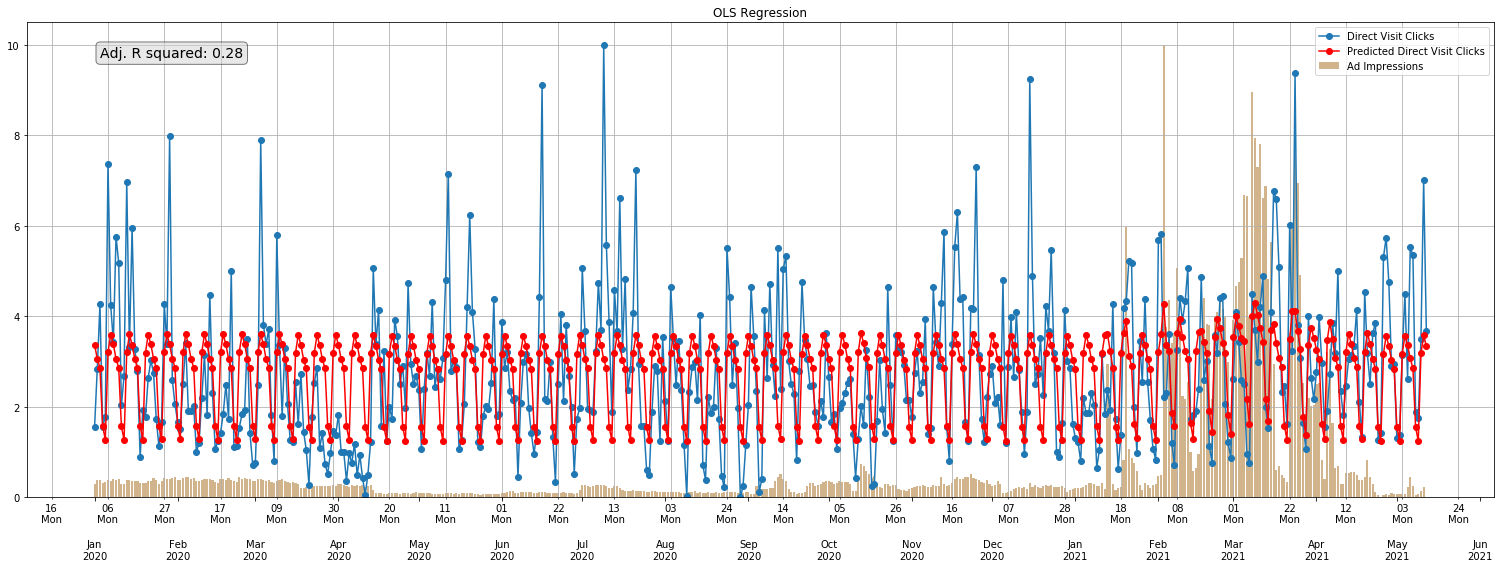

In [9]:
# Initialize model
x = df[['Ad Impressions', 'day_of_the_week_Monday', 'day_of_the_week_Tuesday', 'day_of_the_week_Wednesday',
        'day_of_the_week_Thursday', 'day_of_the_week_Saturday', 'day_of_the_week_Sunday']]
y = df['Direct Visit Clicks']

# Run OLS regression and store results in res
res = model(x, y)
# pd.DataFrame(list(res)).to_csv('fitted.csv')
# xx= []
# for i in list(res.fittedvalues):
#     xx.append(i)

# print(xx)
# for i in list(res.Date):
#     print(i)
# Create plot
fig, ax = plt.subplots(figsize=(21, 8))
df.to_csv('regression.csv')
# Add bar chart representing Ad Impressions values
ax.bar(df.index, df['Ad Impressions'], color='tan', align='center')

# Add line chart representing clicks
ax.plot(df.index, y, 'o-', label="Direct Visit Clicks")
ax.plot(df.index, res.fittedvalues, 'ro-', label="Predicted Direct Visit Clicks")
print('fitted values: ', res.fittedvalues)

# Add text box in upper left in axes coords denoting the R squared of the model
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax.text(0.05, 0.95, "Adj. R squared: {:.2f}".format(res.rsquared_adj), transform=ax.transAxes,
        fontsize=14, verticalalignment='top', bbox=props)

# Set plot options and show plot
ax = apply_date_formatting_to_axis(ax)
ax.legend(['Direct Visit Clicks', 'Predicted Direct Visit Clicks', 'Ad Impressions'], loc='upper right')
plt.title('OLS Regression')
plt.tight_layout()
plt.show()

**Inference**

* Low Adj. R-squared
* The result of this regression shows that some days of the week can be a very important factor for the number of clicks, while other days not:
    * **Tuesday**, **Wednesday** and **Weekends** are statistically significant with low p-values.
* We used Friday as reference day arbitrarily and added binary dummy variables for all other days. The coefficients of these day-dummies can be interpreted as the number of clicks this day has more (or less) compared to the number of clicks on Friday (the reference day). For example, the Saturday coefficient of -1.2836 implies that there are 1.2836 less absolute clicks on Saturday than on Friday.
* Another interesting result is the positive coefficient for the Ad Impressions variable. This coefficient can be interpreted as a positive effect of 0.0930 additional clicks for each Ad Impressions. Note also that this imply a **non-linear** effect of Ad Impressions.

[Go to the top](#top)

### Second Run <a id='fit2'></a>

Run again the OLS regression model using now all the dummy variables.

C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future

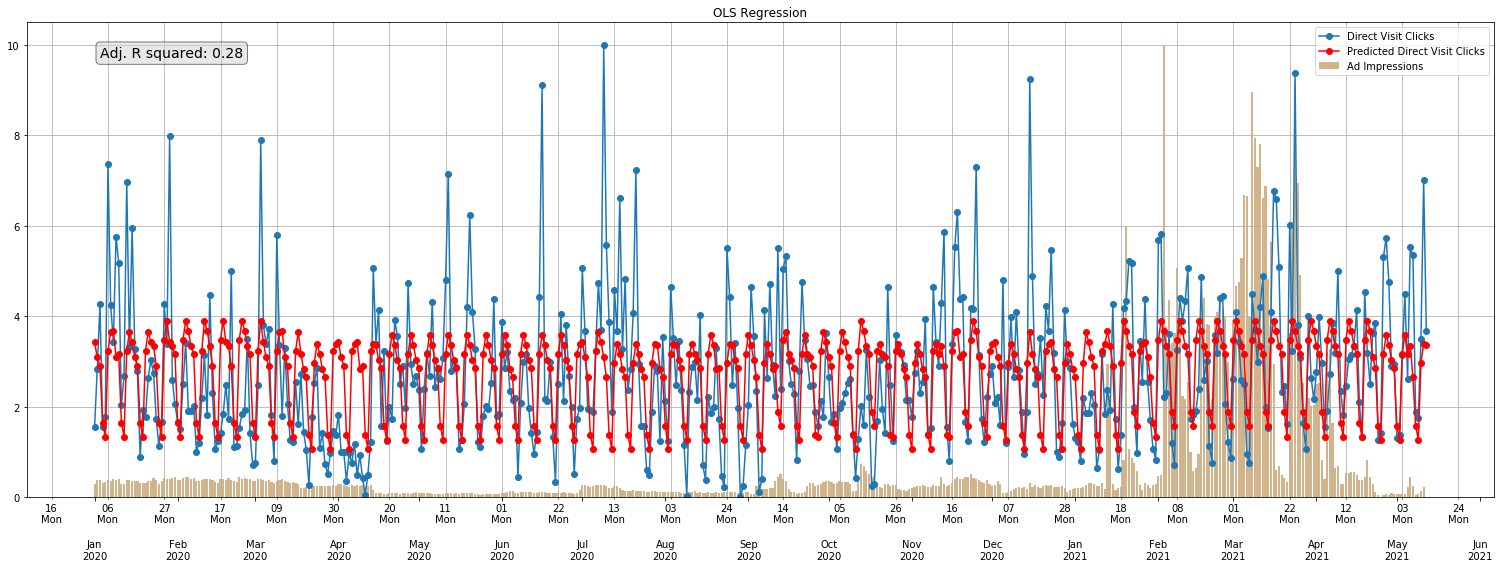

In [10]:
# Initialize model
x = df[['Ad_Impressions_bins_(-0.1, 0.1]', 'Ad_Impressions_bins_(0.1, 0.3]',
        'Ad_Impressions_bins_(0.3, 0.4]', 'Ad_Impressions_bins_(0.4, 10.0]',
        'day_of_the_week_Monday', 'day_of_the_week_Tuesday', 'day_of_the_week_Wednesday',
        'day_of_the_week_Thursday', 'day_of_the_week_Saturday', 'day_of_the_week_Sunday']]
y = df['Direct Visit Clicks']

# Run OLS regression and store results in res
res = model(x, y)

# Create plot
fig, ax = plt.subplots(figsize=(21, 8))

# Add bar chart representing Ad Impressions values
ax.bar(df.index, df['Ad Impressions'], color='tan', align='center')

# Add line chart representing clicks
ax.plot(df.index, y, 'o-', label="Direct Visit Clicks")
ax.plot(df.index, res.fittedvalues, 'ro-', label="Predicted Direct Visit Clicks")

# Add text box in upper left in axes coords denoting the R squared of the model
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax.text(0.05, 0.95, "Adj. R squared: {:.2f}".format(res.rsquared_adj), transform=ax.transAxes,
        fontsize=14, verticalalignment='top', bbox=props)

# Set plot options and show plot
ax = apply_date_formatting_to_axis(ax)
ax.legend(['Direct Visit Clicks', 'Predicted Direct Visit Clicks', 'Ad Impressions'], loc='upper right')
plt.title('OLS Regression')
plt.tight_layout()
plt.show()

**Inference**

* Low Adj. R-squared
* * **Tuesday**, **Wednesday** and **Weekends** are statistically significant with low p-values.
* Using Ad Impressions dummies we simplified the model and we see that all the bins of Ad Impressions are statistically significant.
* Looking at the Ad Impressions bins coefficients, we see that the Ad_Impressions_bins_(0.4, 10.0] increases almost linearly the clicks in a specific day.

[Go to the top](#top)

### Find the S-Curve <a id='s-curve'></a>

Let's plot the additional Direct Visit Clicks against the Ad Impressions intervals. The shape of the S-Curve can be seen in these points. It then is a simple task to find the S-Curve that best fits these points.

In [11]:
# Create function for the s-curve
def logistic_function(x, L=10.0, k=1.25, x_0=5.0):
    """ S-response curve function / logistic function
    :param x: input value that needs to be transformed to a point on the S-curve
    :param L: the curve's maximum value
    :param k: the steepness of the curve
    :param x_0: the x-value of the sigmoid's midpoint
    :return: the value of x as a point on the S-curve
    """
    value = L / (1 + np.exp(-k * (x - x_0)))
    return value

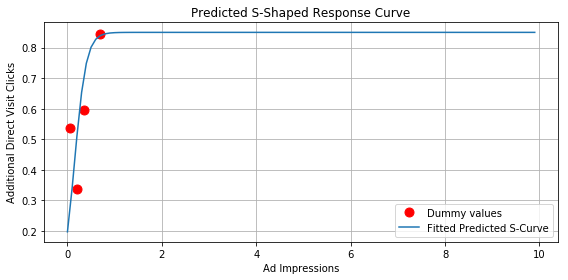

In [12]:
# Initialize plot
fig, ax = plt.subplots(figsize=(8, 4))

# # Plot dummy coefficients
x = [0.05, 0.2, 0.35, 0.7]  # means of Ad Impressions bins
y = [res.params[1], res.params[2], res.params[3], res.params[4]]  # get from previous OLS results
ax.plot(x, y, 'ro', label="Dummy values", markersize=9)


# Plot fitted predicted S-response curve
x = np.arange(0, 10, 0.1)
y = logistic_function(x, L=0.85, k=8, x_0=0.15)
ax.plot(x, y, '-', label="Fitted Predicted S-Curve")

# Set plot options and show plot
ax.legend(loc='lower right')
plt.xlabel('Ad Impressions')
plt.ylabel('Additional Direct Visit Clicks')
plt.title('Predicted S-Shaped Response Curve')
plt.tight_layout()
plt.grid()
plt.show()

**Inference**

* A particular useful property of the S-Curve is the inflection point, which helps to find the optimal spend value on marketing. At the inflection point, the derivative value of the S-Curve is maximized. This implies that at this point the S-Curve changes from increasing returns into diminishing returns. The inflection point is therefore used as the minimum spend value because all spends below this value imply underspending as we can easily increase our ROI if we increase the spend up to the inflection point.
* In our example, the **inflection point** lies at 0.15 normalized Ad Impressions, which is about **28000 Ad Impressions** in denormalized units. Using less than 28000 implies underspending because we can get more clicks per ad impression.
* In a similar manner we can also find the **overspending value**. Above the inflection point, the S-Curve shows **diminishing returns**. This implies that for every additional ad, fewer absolute additional clicks are generated. In our case, at point around 0.8 (**plateau area**) or at more than about **150000 Ad Impressions** is obvious overspending as the additional clicks hardly increase.

[Go to the top](#top)

### Final Run <a id='fit3'></a>

So, since we found our best S-Curve transformation, we run the first OLS regression again but this time with our Ad Impressions transformed to fit the new S-Curve.

C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\EdwardNewGate\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future

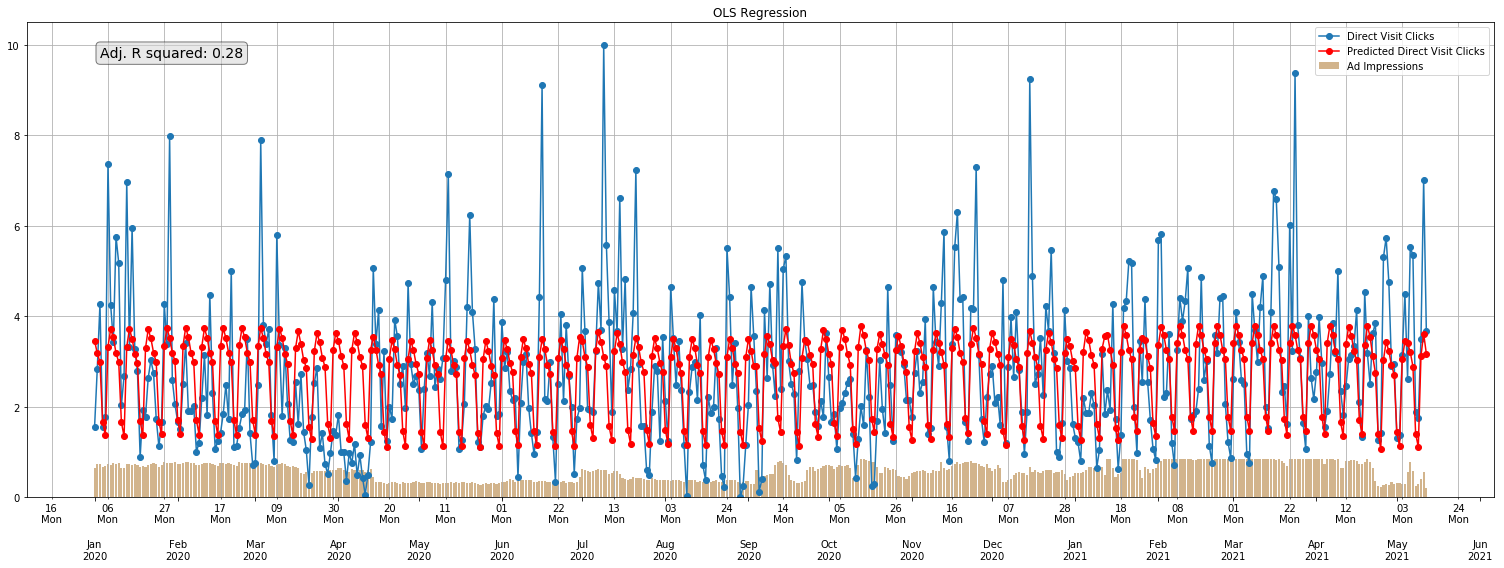

In [13]:
# Transform Ad Impressions based on the previous predicted S-Curve
df['Ad Impressions'] = logistic_function(df['Ad Impressions'], L=0.85, k=8, x_0=0.15)

# Initialize model
x = df[['Ad Impressions', 'day_of_the_week_Monday', 'day_of_the_week_Tuesday', 'day_of_the_week_Wednesday',
        'day_of_the_week_Thursday', 'day_of_the_week_Saturday', 'day_of_the_week_Sunday']]
y = df['Direct Visit Clicks']

# Run OLS regression and store results in res
res = model(x, y)

# Create plot
fig, ax = plt.subplots(figsize=(21, 8))

# Add bar chart representing Ad Impressions values
ax.bar(df.index, df['Ad Impressions'], color='tan', align='center')

# Add line chart representing clicks
ax.plot(df.index, y, 'o-', label="Direct Visit Clicks")
ax.plot(df.index, res.fittedvalues, 'ro-', label="Predicted Direct Visit Clicks")

# Add text box in upper left in axes coords denoting the R squared of the model
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax.text(0.05, 0.95, "Adj. R squared: {:.2f}".format(res.rsquared_adj), transform=ax.transAxes,
        fontsize=14, verticalalignment='top', bbox=props)

# Set plot options and show plot
ax = apply_date_formatting_to_axis(ax)
ax.legend(['Direct Visit Clicks', 'Predicted Direct Visit Clicks', 'Ad Impressions'], loc='upper right')
plt.title('OLS Regression')
plt.tight_layout()
plt.show()

**Inference**

* We didn't get a better fit with S-Curve transformation.

[Go to the top](#top)

## Conclusion <a id='conclusion'></a>

From the optimization and S-Curve analysis we can say that:

* We get Low Adj. R-squared in our models.
* **Tuesday**, **Wednesday** and **Weekends** are statistically significant days on Direct Visit Clicks.
* We get considerably less Direct Visit Clicks on weekends.
* In general Ad Impressions has a non-linear effect on Direct Visit Clicks.
* The inflection point lies at 28000 Ad Impressions, which means that less than this implies underspending because we can get more clicks per ad impression.
* However, above the inflection point, the S-Curve shows **diminishing returns** and in our case, more than about 150000 Ad Impressions is obvious overspending as the additional clicks hardly increase.

Finally, when we get response curves for each of the individual KPI drivers (different campaigns), it is possible to find the optimal spend for each individual campaign using an easy-to-solve optimization problem. The result is an optimal marketing mix that maximizes the chosen KPIs.

[Go to the top](#top)